# M2 fouille de données avancée

## Poblématique : Analyse et prédiction de l'évolution des prix du m² par commune au Luxembourg 

### Objectifs :
- Analyser les facteurs déterminants influençant l'évolution des prix de l'immobilier.

- Créer un modèle prédictif permettant d'anticiper les tendances futures du marché immobilier.


Données nécessaires :
1.	Prix de l'immobilier sur 10 ans par commune. 
2.	Salaire moyenne par commune. 
3.	Densité d’habitation par commune.  
4.	Données sur l'offre de logements (nouvelles constructions).  


Approches :

1. Collecte des données via le portail data.public.lu. (https://data.public.lu/fr/datasets/prix-de-vente-des-appartements-par-commune/#resources)
2. Analyse exploratoire des données (EDA) pour comprendre les tendances et corrélations.
3. Modélisation prédictive pour anticiper l'évolution des prix en utilisant de la régression linéaire et non linéaire.
4. Analyse géospatiale pour visualiser la répartition des prix et identifier les zones d'intérêt.


Résultats attendus :

1. Une carte interactive illustrant les prix de l'immobilier par commune.
2. Des insights sur les facteurs déterminants des variations de prix.


In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
# Importing the dataset
df = pd.read_csv('../dataset/dataset1.csv')
df['Prix moyen au m².1'] = df['Prix moyen au m².1'].str.replace(' ', '')
df['Prix moyen au m².1'] = df['Prix moyen au m².1'].astype(float)
df['Prix moyen au m²'] = df['Prix moyen au m²'].str.replace(' ', '')
df['Prix moyen au m²'] = df['Prix moyen au m²'].astype(float)
print(df.describe())
print(df.info())

       Nombre de ventes  Prix moyen au m²  Nombre de VEFA  Prix moyen au m².1  \
count        227.000000        227.000000      227.000000          227.000000   
mean          62.797357       5767.718062       38.162996         6651.933921   
std           68.680570       1708.771514       31.313641         1872.181922   
min           10.000000       3106.000000       10.000000         3518.000000   
25%           21.000000       4517.500000       16.000000         5343.000000   
50%           40.000000       5191.000000       27.000000         6120.000000   
75%           68.500000       6771.000000       46.500000         7713.500000   
max          343.000000      11639.000000      187.000000        13288.000000   

       Densité par km²        Année  Salaire moyen  
count       227.000000   227.000000     227.000000  
mean        520.533128  2018.083700    5290.635374  
std         476.300794     2.539432    1554.683768  
min          51.500000  2014.000000    3092.260000  
25%  

Text(0.5, 1.0, 'Distribution des prix moyens au m²')

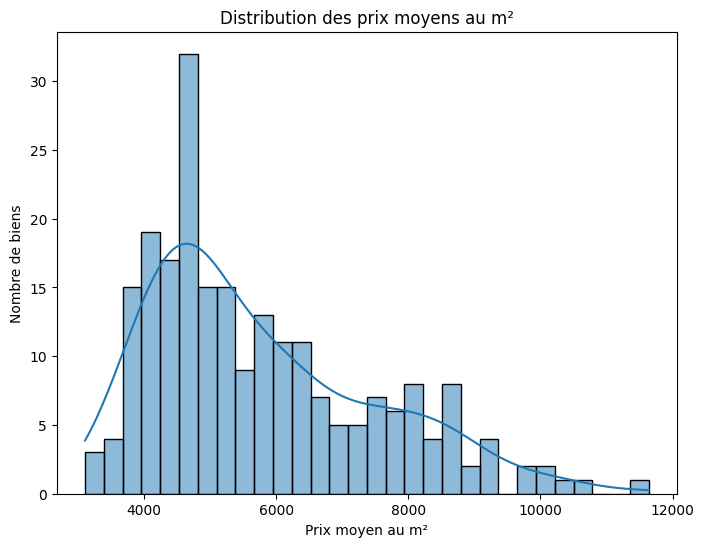

In [4]:
# Distribution du prix au m²
plt.figure(figsize=(8,6))
sns.histplot(df['Prix moyen au m²'], bins=30, kde=True)
plt.ylabel('Nombre de biens')
plt.title('Distribution des prix moyens au m²')

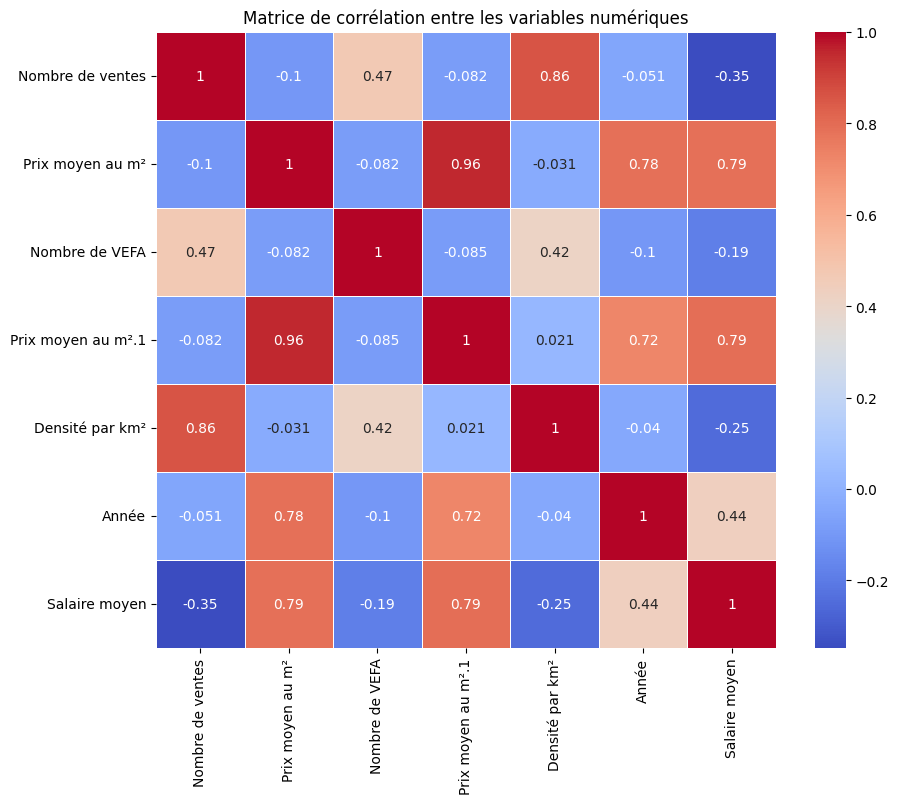

In [5]:
# Sélectionner uniquement les colonnes numériques
df_numeric = df.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation uniquement sur ces colonnes
plt.figure(figsize=(10, 8))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation entre les variables numériques')
plt.show()


Text(0.5, 1.0, 'Relation entre le salaire moyen et le prix au m²')

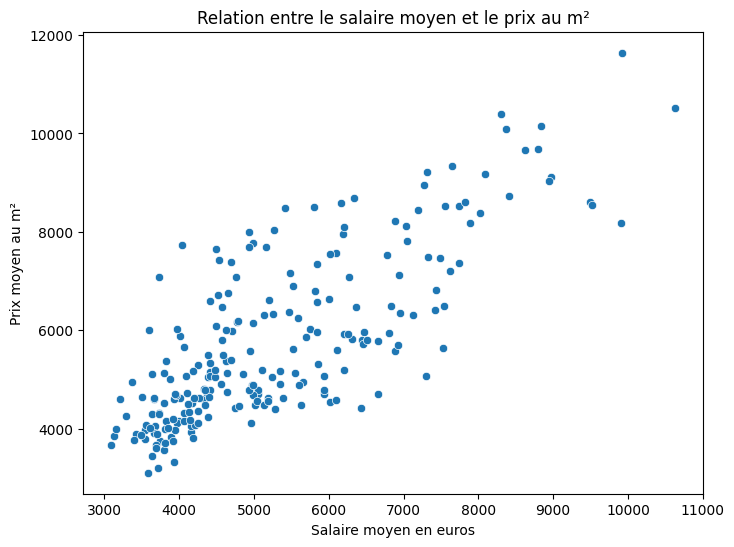

In [6]:
# Scatter plot entre prix au m² et salaire moyen par commune
plt.figure(figsize=(8,6))
sns.scatterplot(x='Salaire moyen', y='Prix moyen au m²', data=df)
# renommer x
plt.xlabel('Salaire moyen en euros')
plt.title('Relation entre le salaire moyen et le prix au m²')

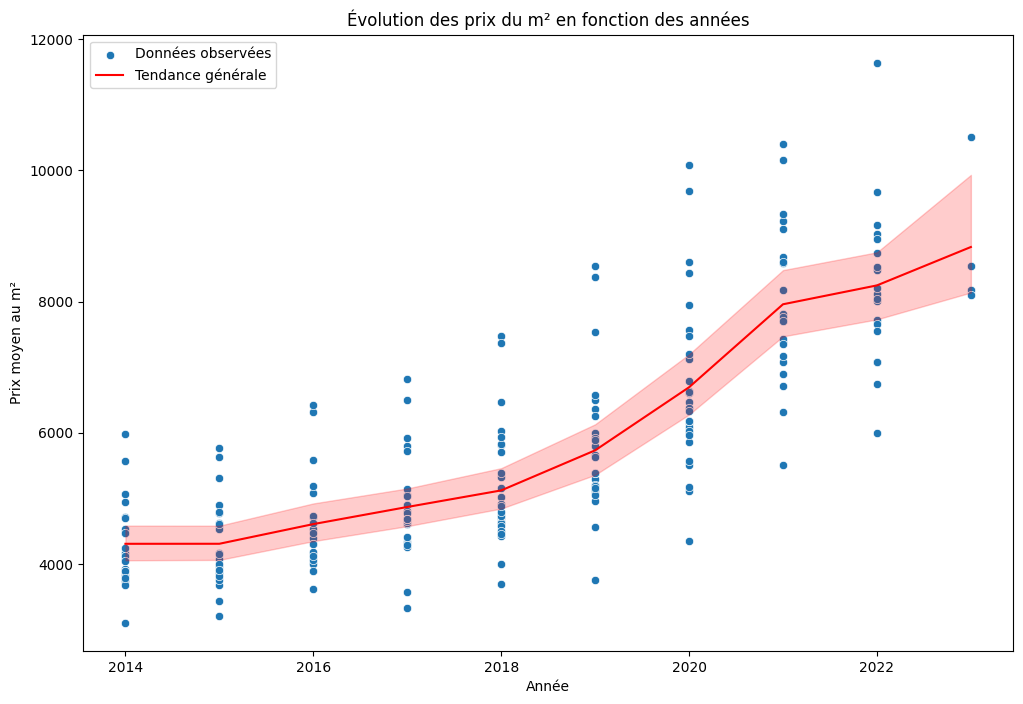

In [7]:
# Combinaison scatter plot et line plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Année', y='Prix moyen au m²', data=df, label='Données observées')
sns.lineplot(x='Année', y='Prix moyen au m²', data=df, color='red', label='Tendance générale')
plt.title('Évolution des prix du m² en fonction des années')
plt.xlabel('Année')
plt.ylabel('Prix moyen au m²')
plt.legend()
plt.show()


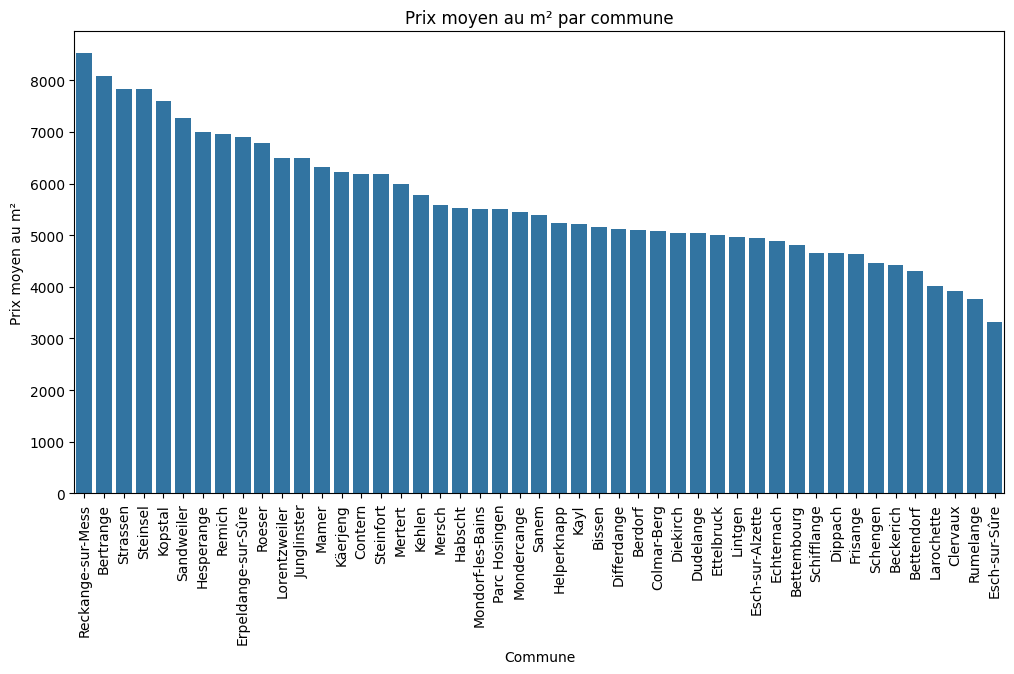

In [8]:
plt.figure(figsize=(12, 6))
avg_price_per_commune = df.groupby('Commune')['Prix moyen au m²'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_per_commune.index, y=avg_price_per_commune.values)
plt.xticks(rotation=90)
plt.title('Prix moyen au m² par commune')
plt.xlabel('Commune')
plt.ylabel('Prix moyen au m²')
plt.show()


In [9]:
df.head()

,Commune,Nombre de ventes,Prix moyen au m²,Nombre de VEFA,Prix moyen au m².1,Densité par km²,Année,Salaire moyen
0,Bertrange,51,5975.0,48,6975.0,377.92,2014,6468.27
1,Bettembourg,40,3925.0,49,5515.0,467.10,2014,4157.58
2,Clervaux,22,3106.0,19,3659.0,55.67,2014,3576.64
3,Diekirch,32,3747.0,56,4816.0,535.35,2014,3738.49
4,Differdange,208,3676.0,131,4084.0,1062.71,2014,3092.26


In [10]:
# Sélection des features et de la target
X = df[['Commune', 'Nombre de ventes', 'Nombre de VEFA','Prix moyen au m².1', 'Densité par km²', 'Année', 'Salaire moyen']]
y = df['Prix moyen au m²']

# Encodage des variables catégorielles
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding pour les communes

# Division en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
linear_regressor = LinearRegression()

# Pas beaucoup d'hyperparamètres pour LinearRegression, on vérifie juste l'ajustement avec ou sans interception
param_grid_lr = {
    'fit_intercept': [True, False],
}

grid_search_lr = GridSearchCV(estimator=linear_regressor, param_grid=param_grid_lr, cv=5, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_train, y_train)

# Meilleurs hyperparamètres et évaluation pour Régression Linéaire
best_params_lr = grid_search_lr.best_params_
print(f"Meilleurs hyperparamètres Régression Linéaire : {best_params_lr}")

y_pred_lr = grid_search_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'MSE (GridSearchCV Régression Linéaire) : {mse_lr}')
print(f'R² (GridSearchCV Régression Linéaire) : {r2_lr}')


Meilleurs hyperparamètres Régression Linéaire : {'fit_intercept': True}
MSE (GridSearchCV Régression Linéaire) : 189708.86258322714
R² (GridSearchCV Régression Linéaire) : 0.9194197126901941


In [12]:
rf_regressor = RandomForestRegressor(random_state=42)

# Grille d'hyperparamètres pour Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Meilleurs hyperparamètres et évaluation pour Random Forest
best_params_rf = grid_search_rf.best_params_
print(f"Meilleurs hyperparamètres Random Forest : {best_params_rf}")

y_pred_rf = grid_search_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'MSE (GridSearchCV Random Forest) : {mse_rf}')
print(f'R² (GridSearchCV Random Forest) : {r2_rf}')

Meilleurs hyperparamètres Random Forest : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MSE (GridSearchCV Random Forest) : 149563.590876087
R² (GridSearchCV Random Forest) : 0.9364717232512314


In [13]:
gb_regressor = GradientBoostingRegressor(random_state=42)
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gb = GridSearchCV(estimator=gb_regressor, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Meilleurs hyperparamètres et évaluation pour Gradient Boosting
best_params_gb = grid_search_gb.best_params_
print(f"Meilleurs hyperparamètres Gradient Boosting : {best_params_gb}")

y_pred_gb = grid_search_gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'MSE (GridSearchCV Gradient Boosting) : {mse_gb}')
print(f'R² (GridSearchCV Gradient Boosting) : {r2_gb}')

Meilleurs hyperparamètres Gradient Boosting : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MSE (GridSearchCV Gradient Boosting) : 135189.4614010118
R² (GridSearchCV Gradient Boosting) : 0.9425772444543948


In [14]:
# Comparer les diffrents modèles dans un tableau
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
mse = [mse_lr, mse_rf, mse_gb]
r2 = [r2_lr, r2_rf, r2_gb]
tab = pd.DataFrame({'Modèle': models, 'MSE': mse, 'R²': r2})
print(tab)

              Modèle            MSE        R²
0  Linear Regression  189708.862583  0.919420
1      Random Forest  149563.590876  0.936472
2  Gradient Boosting  135189.461401  0.942577


# Comparaisons des modèles 
- Le Gradient Boosting est le modèle le plus performant avec une meilleure capacité à généraliser les données, comme le montrent les résultats de la validation croisée.
- Le Random Forest est également un bon candidat, bien qu'il présente une légère baisse de performance en validation croisée par rapport au Gradient Boosting.